In [224]:
import easygui
file_name = easygui.enterbox("Enter the file location of the blog draft to be analyzed")
with open(file_name, 'r') as file:
    doc = file.read().replace('\n', '') 
orig_text =doc

In [225]:
# Libraries for text preprocessing
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

In [226]:
#Remove punctuations
doc = re.sub('[^a-zA-Z]', ' ', doc)

#Convert to lowercase
doc = doc.lower()

#remove tags
doc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",doc)

# remove special characters and digits
doc=re.sub("(\\d|\\W)+"," ",doc)

##Convert to list from string
doc = doc.split()

##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["medium", "show", "result", "also", "previously","article","the","to","of","for","in","our","from","on","it","also"]
stop_words = stop_words.union(new_words)
##Stemming
# ps=PorterStemmer()
#Lemmatisation
lem = WordNetLemmatizer()
text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
doc = " ".join(doc)
print(doc)

supervised learning is the machine learning task of learning a function that maps an input to an output based on example input output pairs it infers a function from labeled training data consisting of a set of training examples in supervised learning each example is a pair consisting of an input object typically a vector and a desired output value also called the supervisory signal a supervised learning algorithm analyzes the training data and produces an inferred function which can be used for mapping new examples an optimal scenario will allow for the algorithm to correctly determine the class labels for unseen instances this requires the learning algorithm to generalize from the training data to unseen situations in a reasonable way see inductive bias


In [227]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (1,2)
# stop_words = "english"

# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
candidates = count.get_feature_names()

In [228]:

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

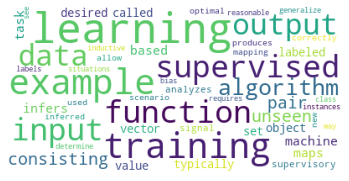

In [229]:
#Word cloud
# %pip install wordcloud --user
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
# for index in range(len(dataset)):
        # temp += df['A'].iloc[index] + df['B'].iloc[index]
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(doc))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word.png", dpi=900)

In [230]:

from sklearn.metrics.pairwise import cosine_similarity

top_n = 10
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
print(keywords)

['training data', 'learning task', 'algorithm analyzes', 'task learning', 'algorithm generalize', 'learning function', 'machine learning', 'supervised learning', 'learning machine', 'learning algorithm']


In [231]:
import numpy as np
import itertools

def max_sum_sim(doc_embedding, word_embeddings, words, top_n, nr_candidates):
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    distances_candidates = cosine_similarity(candidate_embeddings, 
                                            candidate_embeddings)

    # Get top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

    # Calculate the combination of words that are the least similar to each other
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]

In [232]:
import numpy as np

def mmr(doc_embedding, word_embeddings, words, top_n, diversity):

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [233]:
keywords1=max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=10, nr_candidates=20)
print(keywords1)

['algorithm correctly', 'signal supervised', 'requires learning', 'set training', 'generalize training', 'training data', 'algorithm analyzes', 'machine learning', 'supervised learning', 'learning algorithm']


In [234]:
keywords2=mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.7)
print(keywords2)

['learning algorithm', 'labels unseen', 'algorithm correctly', 'new examples', 'generalize training', 'function maps', 'inductive bias', 'supervised learning', 'class labels', 'supervisory signal']


In [235]:
import re
doc1=orig_text
for word in keywords:
    if len(word)==1:
        doc1=re.sub(word,'\033[34m' + str(word) + '\033[0m',doc1,flags=re.I)
    else:
        word1=word.split()[0]
        word2=word.split()[1]
        doc1=re.sub(word1,'\033[34m' + str(word1) + '\033[0m',doc1,flags=re.I)
        doc1=re.sub(word2,'\033[34m' + str(word2) + '\033[0m',doc1,flags=re.I)
print(doc1)

supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.[1] It infers a function from labeled training data consisting of a set of training examples.[2] In supervised learning, each example is a pair consisting of an input object (typically a vector) and a desired output value (also called the supervisory signal). A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples. An optimal scenario will allow for the algorithm  to correctly determine the class labels for unseen instances. This requires the learning algorithm to generalize from the training data to unseen situations in a 'reasonable' way (see inductive bias).


In [236]:
doc2=orig_text
for word in keywords1:
    if len(word)==1:
        doc2=re.sub(word,'\033[34m' + str(word) + '\033[0m',doc2,flags=re.I)
    else:
        word1=word.split()[0]
        word2=word.split()[1]
        doc2=re.sub(word1,'\033[34m' + str(word1) + '\033[0m',doc2,flags=re.I)
        doc2=re.sub(word2,'\033[34m' + str(word2) + '\033[0m',doc2,flags=re.I)
print(doc2)

supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.[1] It infers a function from labeled training data consisting of a set of training examples.[2] In supervised learning, each example is a pair consisting of an input object (typically a vector) and a desired output value (also called the supervisory signal). A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples. An optimal scenario will allow for the algorithm  to correctly determine the class labels for unseen instances. This requires the learning algorithm to generalize from the training data to unseen situations in a 'reasonable' way (see inductive bias).


In [237]:
doc3=orig_text
for word in keywords2:
    if len(word)==1:
        doc3=re.sub(word,'\033[34m' + str(word) + '\033[0m',doc3,flags=re.I)
    else:
        word1=word.split()[0]
        word2=word.split()[1]
        doc3=re.sub(word1,'\033[34m' + str(word1) + '\033[0m',doc3,flags=re.I)
        doc3=re.sub(word2,'\033[34m' + str(word2) + '\033[0m',doc3,flags=re.I)
print(doc3)

supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.[1] It infers a function from labeled training data consisting of a set of training examples.[2] In supervised learning, each example is a pair consisting of an input object (typically a vector) and a desired output value (also called the supervisory signal). A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples. An optimal scenario will allow for the algorithm  to correctly determine the class labels for unseen instances. This requires the learning algorithm to generalize from the training data to unseen situations in a 'reasonable' way (see inductive bias).


In [255]:
print("BERT Model \n")
print("Before Applying Diversification Algorithms\n")
print("Keywords : \n" )
for number, letter in enumerate(keywords):
    print(number+1, letter)
print("\n Article : \n")
print(doc1,"\n\n---------------------------------------------------------------------------------------------------------------------------------\n")

print("After Applying Diversification Algorithm - Max sum Similarity\n")
print("Keywords : \n" )
for number, letter in enumerate(keywords1):
    print(number+1, letter)
print("\n Article : \n")
print(doc2,"\n\n---------------------------------------------------------------------------------------------------------------------------------\n")

print("After Applying Diversification Algorithm - Maximal Marginal Relevance\n")
print("Keywords : \n" )
for number, letter in enumerate(keywords2):
    print(number+1, letter)
print("\n Article : \n")
print(doc3,"\n\n---------------------------------------------------------------------------------------------------------------------------------\n")



BERT Model 

Before Applying Diversification Algorithms

Keywords : 

1 training data
2 learning task
3 algorithm analyzes
4 task learning
5 algorithm generalize
6 learning function
7 machine learning
8 supervised learning
9 learning machine
10 learning algorithm

 Article : 

supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.[1] It infers a function from labeled training data consisting of a set of training examples.[2] In supervised learning, each example is a pair consisting of an input object (typically a vector) and a desired output value (also called the supervisory signal). A supervised learning algorithm analyzes the training data and produces an inferred function, which can be used for mapping new examples. An optimal scenario will allow for the algorithm  to correctly determine the class labels for unseen instances. This requires the learning algorithm to generalize from the training dat